In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, LSTM, SimpleRNN, Dense

## Обмежуємо кількість фіч та слів у реченні в датасеті для швидшого навчання.

In [2]:
num_words = 10000
maxlen = 500

## Завантажуємо датасет

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Перевіряємо довжину першого речення у словах

In [6]:
len(x_train[0])

218

## Нормалізуємо датасет (вирівнюємо кожне речення за однаковою кількістю слів)

In [7]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

## Знову перевіряємо кількість слів у першому реченні, чи дорівнює воно змінній maxlen

In [8]:
len(x_train[0])

500

## Експеримент 1: Навчимо найпростішу RNN модель з шаром SimpleRNN.

In [9]:
model1 = Sequential([
    Embedding(num_words, 32),
    SimpleRNN(32),
    Dense(1, activation="sigmoid")
])

In [10]:
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [11]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Навчаємо модель на 5 епохах, розміром батчів 128 та роздільним коефіцієнтом на валідаційну вибірку 0.3

In [12]:
history1 = model1.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.3)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - acc: 0.5528 - loss: 0.6820 - val_acc: 0.7369 - val_loss: 0.5336
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - acc: 0.7890 - loss: 0.4689 - val_acc: 0.7407 - val_loss: 0.5191
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - acc: 0.8628 - loss: 0.3433 - val_acc: 0.6361 - val_loss: 1.0123
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - acc: 0.8909 - loss: 0.2792 - val_acc: 0.8012 - val_loss: 0.4307
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 202ms/step - acc: 0.9238 - loss: 0.2133 - val_acc: 0.8245 - val_loss: 0.4130


## Візуалізуємо історію тренувальної/валідаційної похибки та точності за допомогою написаної нами функції visualize_history

In [18]:
def visualize_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Точність на тренуванні')
    plt.plot(epochs, val_acc, 'b', label='Точність на валідації')
    plt.title('Точність тренування і валідації')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Втрати на тренуванні')
    plt.plot(epochs, val_loss, 'b', label='Втрати на валідації')
    plt.title('Втрати тренування і валідації')
    plt.legend()

    plt.show()

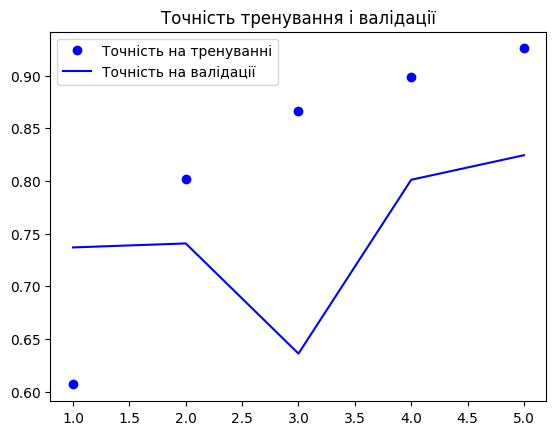

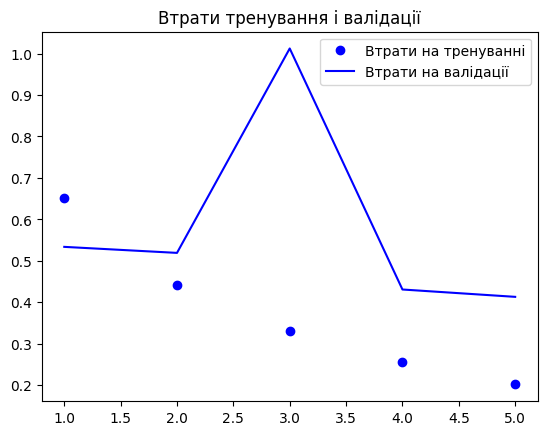

In [19]:
visualize_history(history1)

## На графіку точності видно, що валідаційна точність сильно відрізняється від тренувальної точності, а спричинено це затуханням градієнту. Щоб вирішити цю проблему, треба скористатися алгоритмом GRU або LSTM.

## Перевіримо модель на тестових даних, подивимось на частку предиктів моделі та правильних відповідей

In [20]:
def pred_eval(model, x_test, y_test):
    predictions = model.predict(x_test)

    binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

    for i in range(10):
        print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {y_test[i]}")

    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))

In [21]:
pred_eval(model1, x_test, y_test)

721/721 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
721/721 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - acc: 0.8246 - loss: 0.4131
Test Loss: 0.40788599848747253
Test Accuracy: 0.829221785068512


## Виявилось, що модель має точність 82.9%, що є дуже слабким результатом, а похибка дуже велика для адекватної моделі (0.4).

## Експеримент 2: Модель за алгоритмом GRU

In [16]:
model2 = Sequential([
    Embedding(num_words, 32),
    GRU(32),
    Dense(1, activation="sigmoid")
])

model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
history2 = model2.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.3)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 67s 514ms/step - acc: 0.5413 - loss: 0.6836 - val_acc: 0.6057 - val_loss: 0.6493
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 76s 470ms/step - acc: 0.7743 - loss: 0.4723 - val_acc: 0.8087 - val_loss: 0.4281
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 85s 493ms/step - acc: 0.8424 - loss: 0.3644 - val_acc: 0.8484 - val_loss: 0.3522
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 84s 507ms/step - acc: 0.8706 - loss: 0.3075 - val_acc: 0.8460 - val_loss: 0.3570
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 486ms/step - acc: 0.8916 - loss: 0.2740 - val_acc: 0.8655 - val_loss: 0.3181


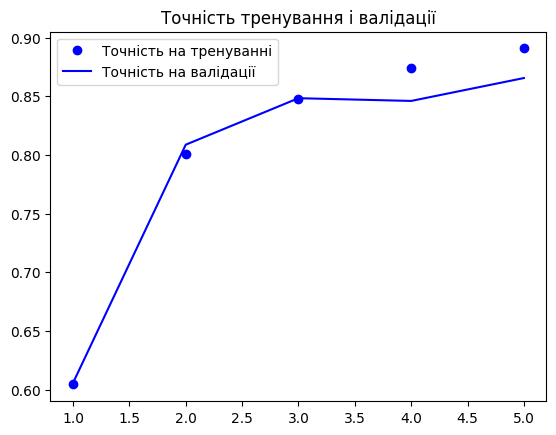

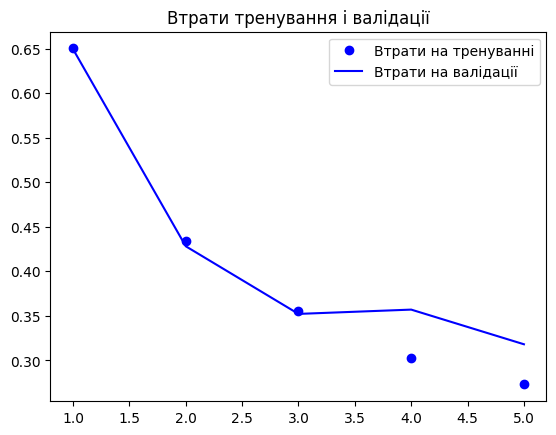

In [22]:
visualize_history(history2)

## На графіках вже валідаційна похибка та точність ближча до тренувальних. Це вирішило проблему затухання градієнту

In [23]:
pred_eval(model2, x_test, y_test)

721/721 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
721/721 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - acc: 0.8625 - loss: 0.3205
Test Loss: 0.31873050332069397
Test Accuracy: 0.8638629913330078


## Точність вже значно краща (86.3%), а похибка менша (0.31), ніж у попередньої моделі, тим більше, ми ще й не допускаємо затухання градієнта.

## Експеримент 3: Модель за алгоритмом LSTM, трохи складнішим за GRU

In [27]:
model3 = Sequential([
    Embedding(num_words, 32),
    LSTM(32),
    Dense(1, activation="sigmoid")
])

model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
history3 = model3.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.3)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 55s 418ms/step - acc: 0.5790 - loss: 0.6730 - val_acc: 0.7752 - val_loss: 0.4749
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 78s 387ms/step - acc: 0.8058 - loss: 0.4373 - val_acc: 0.8465 - val_loss: 0.3735
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 50s 394ms/step - acc: 0.8601 - loss: 0.3414 - val_acc: 0.8278 - val_loss: 0.3922
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 49s 387ms/step - acc: 0.8822 - loss: 0.3014 - val_acc: 0.8382 - val_loss: 0.3699
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 428ms/step - acc: 0.8943 - loss: 0.2676 - val_acc: 0.8641 - val_loss: 0.3261


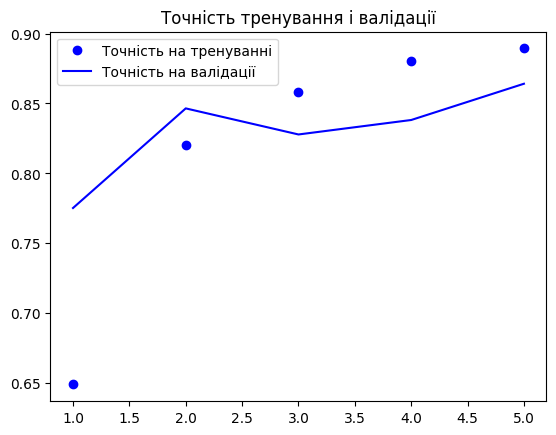

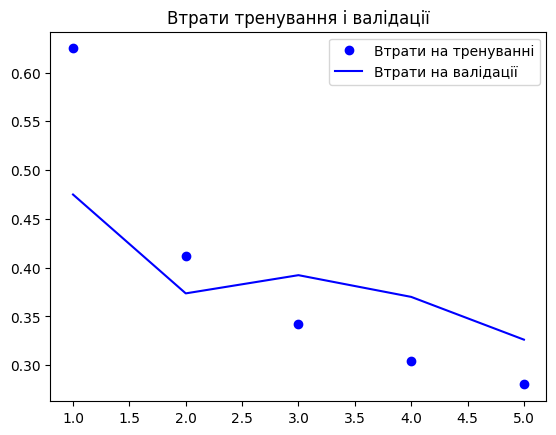

In [29]:
visualize_history(history3)

## На графіках також видно, що затухання градієнта не відбувається і валідаційна точність повільно зростає, а похибка - спадає, результат схожий на результат попередньої моделі

In [30]:
pred_eval(model3, x_test, y_test)

721/721 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
721/721 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - acc: 0.8596 - loss: 0.3281
Test Loss: 0.32452714443206787
Test Accuracy: 0.8611749410629272


## Точність (86.1%) та похибка (0.32), майже така сама, як у попередньої моделі (GRU), і ця модель також не допустила затухання градієнта.

## Експеримент 4: Двосторонній алгоритм LSTM шару

In [32]:
model4 = Sequential([
    Embedding(num_words, 32),
    Bidirectional(LSTM(32)),
    Dense(1, activation="sigmoid")
])

model4.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model4.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
history4 = model4.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.3)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 88s 672ms/step - acc: 0.5219 - loss: 0.6902 - val_acc: 0.6900 - val_loss: 0.5996
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 141s 663ms/step - acc: 0.7639 - loss: 0.5215 - val_acc: 0.8205 - val_loss: 0.4120
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 143s 670ms/step - acc: 0.8424 - loss: 0.3704 - val_acc: 0.8532 - val_loss: 0.3438
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 141s 664ms/step - acc: 0.8856 - loss: 0.2996 - val_acc: 0.7808 - val_loss: 0.4765
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 143s 672ms/step - acc: 0.8750 - loss: 0.3106 - val_acc: 0.8554 - val_loss: 0.4107


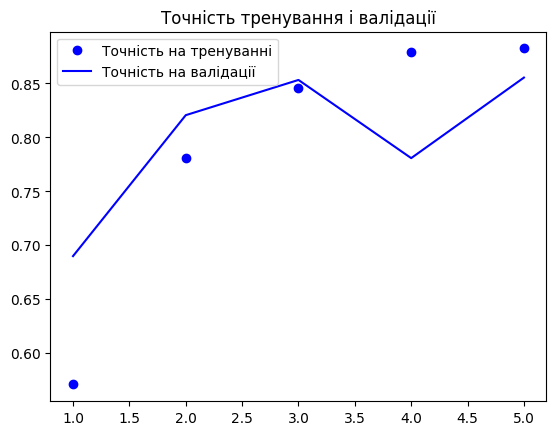

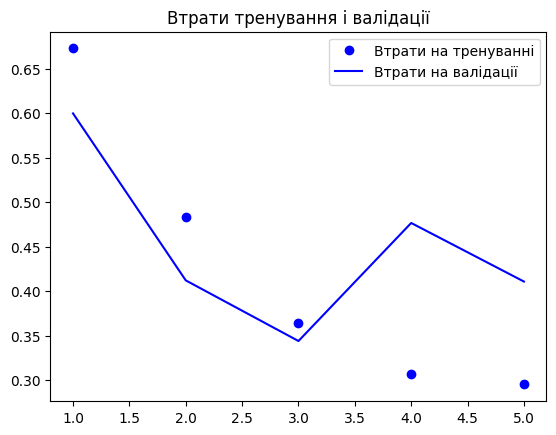

In [34]:
visualize_history(history4)

## Тут ми можемо побачити, що валідаційна похибка набагато вища, ніж тренувальна. Це може бути пов'язано з ускладенням моделі, яка потребує більшої кількості епох навчання, щоб нармалізувати похибку

In [35]:
pred_eval(model4, x_test, y_test)

721/721 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
721/721 ━━━━━━━━━━━━━━━━━━━━ 60s 83ms/step - acc: 0.8447 - loss: 0.4295
Test Loss: 0.4263221323490143
Test Accuracy: 0.846173882484436


## Результат трохи гірший за попередні дві моделі (точність - 84.6%, похибка - 0.42), але якщо додати кількість епох, то результат може бути кращим за результат попередніх моделей, так як двостороння рекурентна нейромережа має глибші розрахунки ваг, що надає їй змогу краще узагальнювати свої передбачення на нових даних

## Експеримент 5: Глибока нейромережа. Додаємо ще один прихований шар у модель

In [36]:
model5 = Sequential([
    Embedding(num_words, 32),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation="sigmoid")
])

model5.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model5.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
history5 = model5.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.3)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - acc: 0.5235 - loss: 0.6832 - val_acc: 0.6795 - val_loss: 0.6055
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - acc: 0.7905 - loss: 0.4622 - val_acc: 0.8561 - val_loss: 0.3423
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - acc: 0.8557 - loss: 0.3517 - val_acc: 0.7765 - val_loss: 0.6103
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - acc: 0.8706 - loss: 0.3204 - val_acc: 0.8548 - val_loss: 0.3761
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.9066 - loss: 0.2437 - val_acc: 0.8747 - val_loss: 0.3370


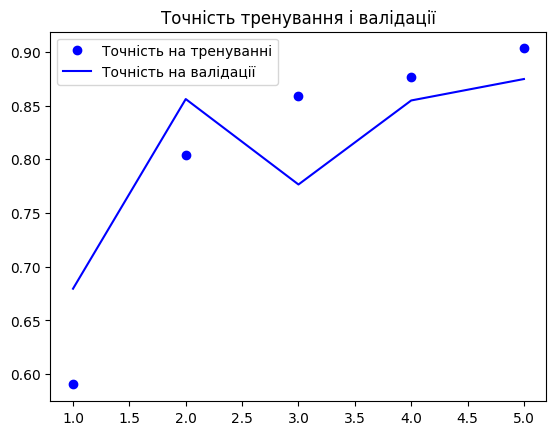

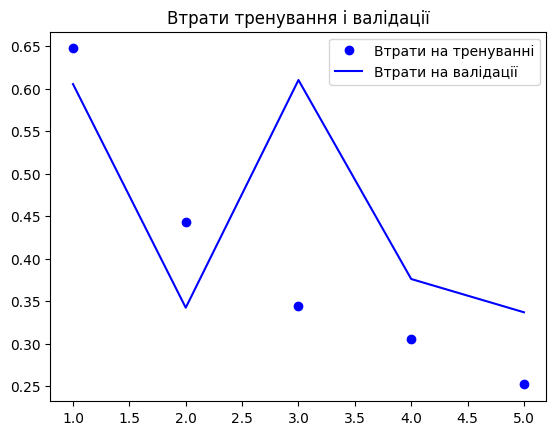

In [38]:
visualize_history(history5)

## Результати похибки та точності на графіку вже кращі за результати одношарової двосторонньої рекурентної нейромережі

In [39]:
pred_eval(model5, x_test, y_test)

721/721 ━━━━━━━━━━━━━━━━━━━━ 123s 170ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
721/721 ━━━━━━━━━━━━━━━━━━━━ 130s 181ms/step - acc: 0.8661 - loss: 0.3528
Test Loss: 0.34742313623428345
Test Accuracy: 0.8682852983474731


## Точність такої моделі дорівнює 86.8%, а це найкращий результат серед усіх проведених експериментів. Похибка дорівнює 0.34. Тепер якщо додати кількість епох до моделі, то ми отримаємо ще кращі результати передбачень, так як ця модель складніша та усуває усі недоліки попередніх моделей.

## Висновки:
## Перша модель була дуже простою для навчання і продемонструвала досить низькі показники точності на тестових даних, а пов'язано це з затуханням градієнта, що не давало моделі можливості змінювати ваги коефіцієнтів на більшій кількості епох
## Друга модель (GRU) вже вирішила проблему затухання градієнта і показала кращий результат
## Третя модель (LSTM) була дуже схожа на модель GRU по результатам навчання та також вирішила проблему з затуханням градієнта
## Четверта модель (ускладнена обчисленням даних у двох напрямках, тобто Bidirectional LSTM) показала трохи гірший результат за попередні два експерименти, саме через її недостатнє тренування
## П'ята модель (глибока нейромережа) найкраще з усіх навчилася та мала високі показники точності серед усіх моделей. Саме цю модель можна тепер донавчити на більшій кількості епох і отримати дуже високі результати точності